# Synthetic data initial condition

# Visualize library terms

0.09592747585483975 0.15143917408436805
(78, 2, 2, 216, 135) (78, 2, 216, 135) (78, 2, 2, 216, 135)
0.029463373977059473 0.007592336598395583 -7.473474665265713e-05


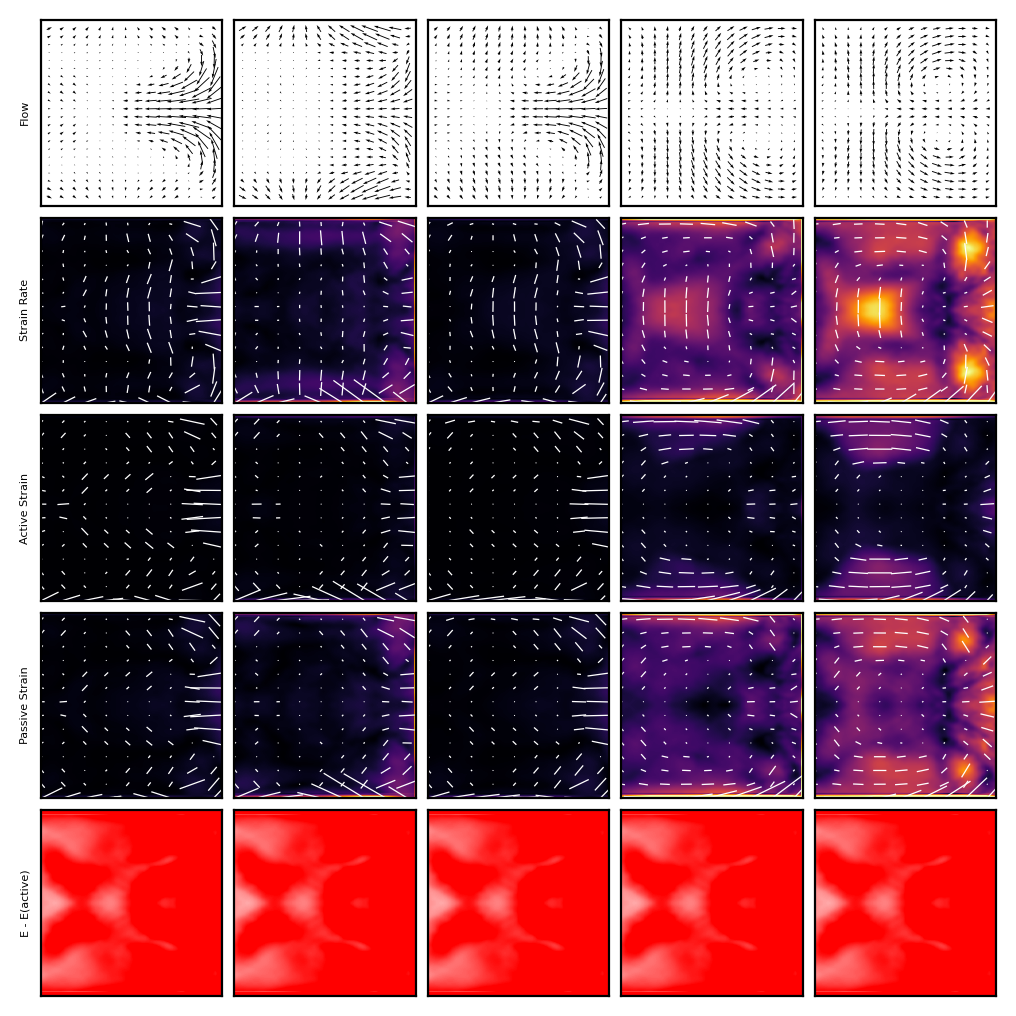

In [13]:
from math import ceil
from utils.plot_utils import *

traj = 0
tts = [0, 10, 20, 30, 40]
skip = 16
plt.rcParams['font.size'] = 4
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.cmap'] = 'inferno'

model = pk.load(open('data/WT/ECad-GFP/decomposition_models/cyt_SVDPipeline_PMG_CF.pkl', 'rb'))
mask = model['masker'].mask_
ys, xs = np.where(mask!=0) 
crop_mask = np.s_[..., min(ys):max(ys)+1, min(xs):max(xs)+1]
mask = mask[crop_mask]

fig, ax = plt.subplots(5, len(tts), dpi=200, figsize=(len(tts), 5))

with h5py.File('data/symmetric_dynamics_fitting.h5', 'r') as h5f:
    embryoID = 'ensemble'
    lib = h5f['202001280915']
    fields = lib['fields']
    
    m = fields['m_ij'][crop_mask][()]
    mnorm = np.linalg.norm(m, axis=(1, 2))
    mmin = mnorm.mean()
    mmax = mnorm.max()
    
    print(mmin, mmax)

    v = fields['v'][crop_mask][()]
    
    E = lib['links']['v']['tensor_library']['E'][crop_mask][()]
    
    E_mag = np.linalg.norm(E, axis=(1, 2))
    emin = E_mag.min()
    emax = emin + 3 * E_mag.std()
    
    print(E.shape, v.shape, m.shape)
        
    deviatoric = m - 0.5 * np.einsum('bkkyx,ij->bijyx', m, np.eye(2))
    
    m0 = np.linalg.norm(m, axis=(1, 2), keepdims=True).mean(axis=(3, 4), keepdims=True)
    dev_mag = np.linalg.norm(deviatoric, axis=(1, 2), keepdims=True)
        
    devE = np.einsum('bklyx,bklyx->byx', deviatoric, E)[:, None, None]
    
    E_active = E - np.sign(devE) * devE * deviatoric / dev_mag**2
    E_active = 0.5 * E_active * dev_mag / m0
    
    E_passive = E - E_active
    
    E_a_mag = np.linalg.norm(E_active, axis=(1, 2))
    
    E_proj_a = np.einsum('bklyx,bklyx->byx', E_active, E)[:, None, None] * E_active / E_a_mag[:, None, None]**2
    E_proj_a_mag = np.linalg.norm(E_proj_a, axis=(1, 2))
    
    print(E_mag.mean(), E_a_mag.mean(), E_proj_a.mean())
        
    #m[..., ~mask] = np.nan
    #v[..., ~mask] = np.nan
    #E[..., ~mask] = np.nan
    #E_passive[..., ~mask] = np.nan
    #E_active[..., ~mask] = np.nan
    
    kwargs = dict(vmin=mmin, vmax=mmax, skip=skip)
    ewargs = dict(vmin=emin, vmax=emax, skip=skip)
    
    for i, tt in enumerate(tts):
        ti = np.argmin(np.abs(lib['t'][()] - tt))
        plot_vector2D(ax[0, i], v[ti])
        plot_tensor2D(ax[1, i], E[ti], **ewargs)
        plot_tensor2D(ax[2, i], E_active[ti], **ewargs)
        plot_tensor2D(ax[3, i], E_proj_a[ti], **ewargs)
        #color_2D(ax[4, i], E_mag[ti] - E_a_mag[ti], vmin=-emax, vmax=emax, cmap='bwr')
        color_2D(ax[4, i], E_proj_a_mag - E_a_mag, cmap='bwr', vmin=-emax, vmax=emax)

        
    ax[0, 0].set_ylabel('Flow')
    ax[1, 0].set_ylabel('Strain Rate')
    ax[2, 0].set_ylabel('Active Strain')
    ax[3, 0].set_ylabel('Passive Strain')
    ax[4, 0].set_ylabel('E - E(active)')
    

    for a in ax.flatten():
        a.set_aspect('auto')
    
    plt.tight_layout()

{'m_ij': 0.12158953709520759, 'v': 1.405064889330702, 'c': 1.9264380660144798}


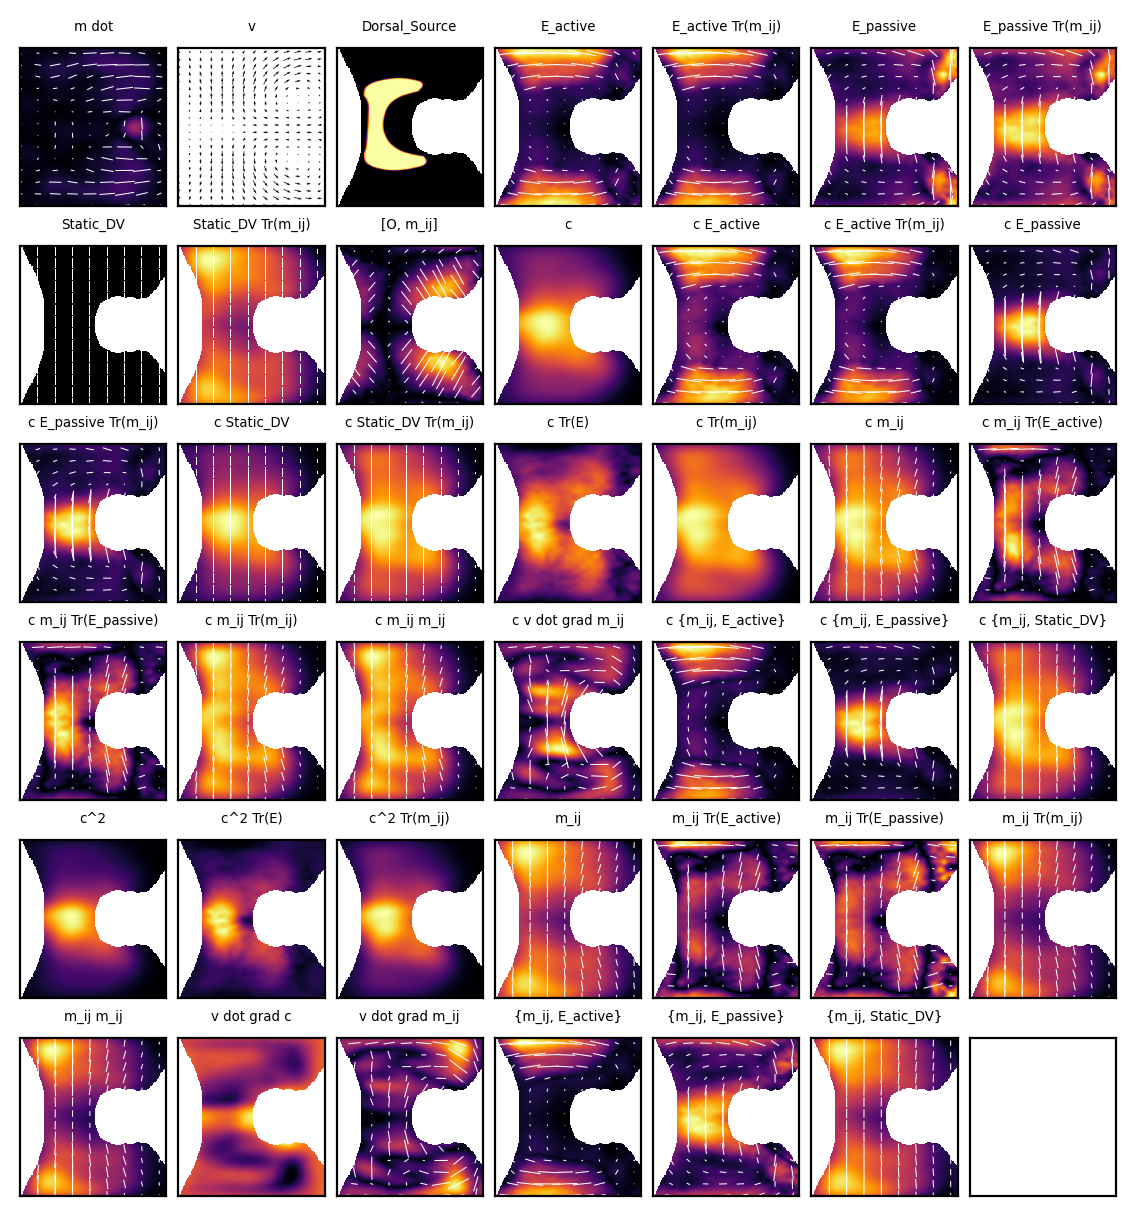

In [5]:
from math import ceil
from utils.plot_utils import *

traj = 0
tt = 35
skip = 16
plt.rcParams['font.size'] = 4
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.cmap'] = 'inferno'

model = pk.load(open('data/WT/ECad-GFP/decomposition_models/cyt_SVDPipeline_PMG_CF.pkl', 'rb'))
mask = model['masker'].mask_
ys, xs = np.where(mask!=0) 
crop_mask = np.s_[..., min(ys):max(ys)+1, min(xs):max(xs)+1]
mask = mask[crop_mask]

with h5py.File('data/symmetric_dynamics_fitting.h5', 'r') as h5f:
    embryoID = 'ensemble'
    lib = h5f[embryoID]
    fields = lib['fields']
    ti = np.argmin(np.abs(lib['t'][()] - tt))
    
    means = {
        'm_ij': np.linalg.norm(fields['m_ij'], axis=(1, 2)).mean(),
        'v': np.linalg.norm(fields['v'], axis=1).mean(),
        'c': np.mean(fields['c'])
    }
    print(means)
    keys = list(lib['X_raw'].keys()) #+ list(lib['U_raw'].keys())
    n_plots = 2 + len(keys)

    n_cols = 7
    n_rows = ceil(n_plots / n_cols)
    fig, ax = plt.subplots(n_rows, n_cols, 
                       figsize=(.8*n_cols, n_rows),
                       sharey=True, sharex=True, dpi=200)

    m_dot = lib['X_dot/m_ij'][..., 0][ti][crop_mask]
    m = fields['m_ij'][crop_mask]
    mnorm = np.linalg.norm(m, axis=(1, 2))[:, mask]
    vmin = mnorm.min()
    vmax = mnorm.max()
    
    ax = ax.flatten()
    ax[0].set_title('m dot')
    plot_tensor2D(ax[0], m_dot, vmin=0, vmax=np.std(mnorm), skip=skip)
    ax[0].set_aspect('auto')
    
    ax[1].set_title('v')
    plot_vector2D(ax[1], lib['fields/v'][ti][()][crop_mask])
    
    raw = lib['X_raw']
    for i, key in enumerate(keys):
        feat = lib['X_raw'][key][ti][crop_mask]
        feat[..., ~mask] = np.nan
        
        if lib['X_raw'][key].attrs['space'] > 0:
            kwargs = dict(vmin=0, vmax=np.std(mnorm))
        else:
            kwargs = dict(vmin=vmin, vmax=vmax)
        
        if len(lib['X_raw'][key].shape) == 3:            
            color_2D(ax[i+2], feat)
        else:
            fnorm = np.linalg.norm(feat, axis=(0, 1))[..., mask]
            plot_tensor2D(ax[i+2], feat[()], skip=skip, linewidth=0.007)
        ax[i+2].set_title(key)
        ax[i+2].set_aspect('auto')

    plt.tight_layout()

# Advected dorsal source

(36, 236, 200)


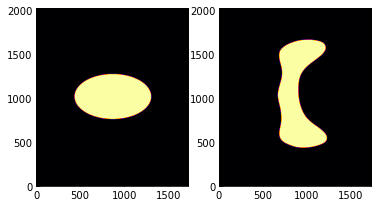

In [24]:
from PIL import Image
from skimage.transform import resize
from skimage.morphology import binary_dilation, binary_erosion

import numpy as np
import matplotlib.pyplot as plt

key='RECTANGLE'
key = 'ELLIPSE_A=0.5_B=0.25'
base = 'dorsal_mask_%s_advected' % key
#dorsal_mask = Image.open('Public/%s.tif' % base)

fig, ax = plt.subplots(1, 2)

mask = []
i = 0
while True:
    try:
        dorsal_mask.seek(i)
        mask.append(resize(np.array(dorsal_mask), (236, 200)))
        if i == 0:
            ax[0].imshow(dorsal_mask)
        i = i + 1
    except Exception as e:
        break

ax[1].imshow(dorsal_mask)
print(np.stack(mask).shape)
mask = np.stack(mask)
np.save('Public/%s_RESIZED.npy' % base, mask)

(36, 236, 200)


[[], []]

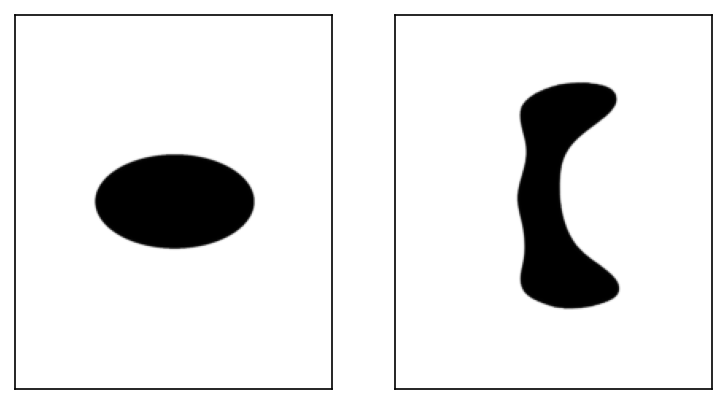

In [28]:
import numpy as np
import matplotlib.pyplot as plt
mask = np.load('Public/%s_RESIZED.npy' % base, mmap_mode='r')
print(mask.shape)
fig, ax = plt.subplots(1, 2, dpi=150)
ax[0].imshow(mask[0], cmap='Greys')
ax[1].imshow(mask[-1], cmap='Greys')

ax[0].set(xticks=[], yticks=[])
ax[1].set(xticks=[], yticks=[])

ELLIPSE_A=0.25_B=0.25
ELLIPSE_A=0.5_B=0.25
ELLIPSE_A=0.6_B=0.25


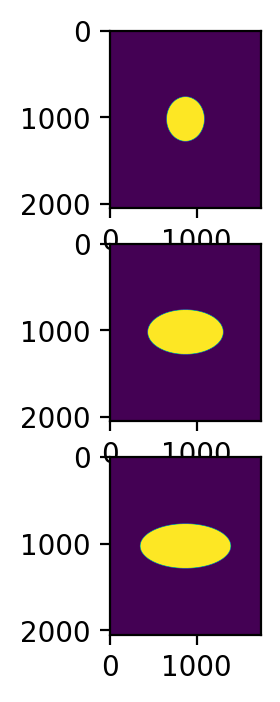

In [21]:
from itertools import product
As = [0.25, 0.5, 0.6]
Bs = [0.25]

fig, ax = plt.subplots(len(As), len(Bs), dpi=200)
ax = ax.flatten()
i = 0

for A, B in product(As, Bs):
    initial = np.zeros((2050, 1738))
    YY, XX = np.mgrid[:2050, :1738]
    YY = 2 * (YY - np.mean(YY)) / np.ptp(YY)
    XX = 2 * (XX - np.mean(XX)) / np.ptp(XX)
    mask = (XX/A)**2 + (YY/B)**2 < 1
    key = 'ELLIPSE_A=%g_B=%g' % (A, B)
    initial[mask] = 1

    print(key)
    ax[i].imshow(initial)
    i += 1

# Posterior midgut + Cephallic furrow mask

(236, 200)


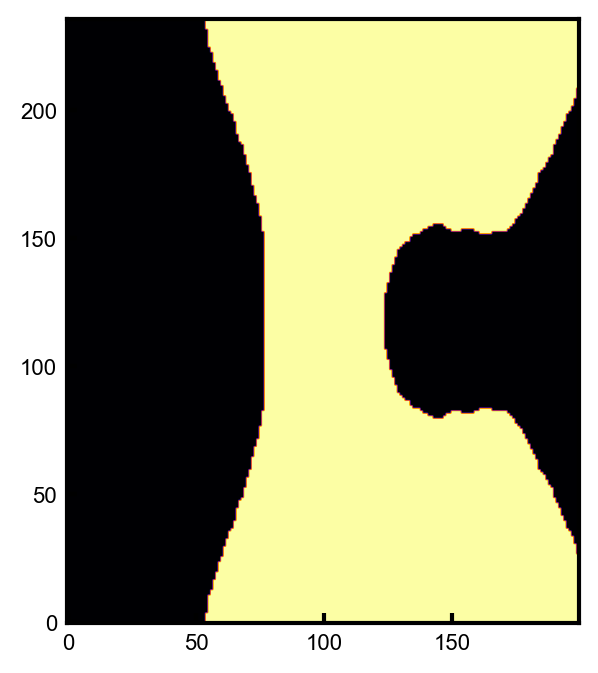

In [102]:
from PIL import Image
from skimage.transform import resize
from skimage.morphology import binary_dilation, binary_erosion
pmg_mask = np.array(Image.open('Public/MAX_WT_PMG_mask.tif'))
cf_mask = np.array(Image.open('Public/MAX_WT_CF_mask.tif'))

pmg_mask = np.array(pmg_mask)
cf_mask = np.array(cf_mask)
total_mask = resize(pmg_mask + cf_mask, (236, 200))
total_mask = (total_mask + total_mask[::-1]) > 0
n = 3
total_mask = ~binary_erosion(total_mask, np.ones([n, n]))
total_mask
print(total_mask.shape)
plt.imshow(total_mask)
np.save('Public/pmg_cf_mask', total_mask)

# Create SVD models

In [1]:
from utils.dataset import *
from torchvision.transforms import Compose
from atlas_processing.anisotropy_detection import cell_size

transform = Reshape2DField()
cad_dataset = AtlasDataset('WT', 'ECad-GFP', 'cyt2D', transform=Compose([transform, Smooth2D(sigma=cell_size)]))
cad_vel_dataset = AtlasDataset('WT', 'ECad-GFP', 'velocity2D', transform=transform)
sqh_dataset = AtlasDataset('Halo_Hetero_Twist[ey53]_Hetero', 'Sqh-GFP', 'tensor2D', transform=transform, drop_no_time=False)
sqh_vel_dataset = AtlasDataset('Halo_Hetero_Twist[ey53]_Hetero', 'Sqh-GFP', 'velocity2D', transform=transform, drop_no_time=False)

/project/vitelli/jonathan/REDO_fruitfly/src/atlas_processing/windowed_radon.py:300: RuntimeWarning: divide by zero encountered in true_divide
  line_weights = 1/(2*np.sqrt(e_len**2-(delta)**2))
100%|██████████| 6/6 [00:00<00:00, 317.32it/s]


In [2]:
from utils.decomposition_utils import *

pmg_cf_mask = np.load('Public/pmg_cf_mask.npy')


sqh_info = get_decomposition_results(sqh_dataset, overwrite=True, crop=10, model_name='SVDPipeline_PMG_CF', mask=pmg_cf_mask)
sqh_info = get_decomposition_results(sqh_dataset, overwrite=True, crop=10)

cad_info = get_decomposition_results(cad_dataset, overwrite=True, crop=10, model_name='SVDPipeline_PMG_CF', mask=pmg_cf_mask)
cad_info = get_decomposition_results(cad_dataset, overwrite=True, crop=10)

cad_vel_info = get_decomposition_results(cad_vel_dataset, overwrite=True, crop=10)
sqh_vel_info = get_decomposition_results(sqh_vel_dataset, overwrite=True, crop=10)

#runt_info = get_decomposition_results(runt_dataset, overwrite=True, crop=10, model_name='SVDPipeline_PMG_CF', mask=pmg_cf_mask)
#runt_info = get_decomposition_results(runt_dataset, overwrite=True, crop=10)

Building new SVDPipeline for this dataset
Building new SVDPipeline for this dataset
Building new SVDPipeline for this dataset
Building new SVDPipeline for this dataset
Building new SVDPipeline for this dataset
Building new SVDPipeline for this dataset
